---
title: "Text Classification for Tweet Sentiment Analysis"
---
In this section, we will be using our text data to create a Naive Bayes text classification model that predicts the sentiment behind individual tweets. Analyzing tweet sentiment is valuable in that it will allow us to look at tweets related to specific races, horses, courses, etc., in order to more succesfully pin down why betting odds are moving the way they are within HKJC's parimutel betting market. Public betting is the sole factor that goes into the generation of odds on horse racing outcomes, so having a model that is able to analyze public perception surrouning HJKC horse racing will allow us to more succesfully pin down why certain horses are seeing various odds movements and insight to how we should we be making our own decisions behind betting horse winners.

This section will be completed using Python.

# Creating a Sentiment Classifier

In [14]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import re
import string
import nltk
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import shutil
from scipy.sparse import csr_matrix
from scipy.sparse import csr_array

Reading in our data.

In [1]:
x = np.array(pd.read_csv("../../../data/01-modified-data/tweet.csv"))
y = np.array(pd.read_csv("../../../data/01-modified-data/sentiment.csv"))

We will now split our data into a training, validation, and test set.

In [4]:
import random
N=x.shape[0]
l = [*range(N)]     # indices
cut = int(0.8 * N) #80% of the list
cut2 = int((N - cut)/2 + cut)
random.shuffle(l)   # randomize
train_index = l[:cut] # first 80% of shuffled list
validate_index = l[cut:cut2] # 10% of shuffled list
test_index = l[cut2:] # 10% of shuffled list

print(train_index[0:10])
print(validate_index[0:10])
print(test_index[0:10])

[13411, 22009, 8006, 21057, 6941, 13517, 17470, 19809, 14337, 4075]
[25334, 5091, 1614, 3412, 24419, 6923, 20932, 15542, 25584, 11058]
[4600, 688, 22928, 7036, 5157, 10458, 5064, 24421, 25429, 14152]


We will now define a function that trains a Multinomial Naive Bayes classifier. We will test our function with our train and test data.

In [5]:
# Training Function
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import time

def train_MNB_model(X,Y,i_print=False):

    if(i_print):
        print(X.shape,Y.shape)

    #SPLIT
    x_train=X[train_index]
    y_train=Y[train_index].flatten()

    x_test=X[test_index]
    y_test=Y[test_index].flatten()

    # INITIALIZE MODEL 
    model = MultinomialNB()

    # TRAIN MODEL 
    start = time.process_time()
    model.fit(x_train,y_train)
    time_train=time.process_time() - start

    # LABEL PREDICTIONS FOR TRAINING AND TEST SET 
    start = time.process_time()
    yp_train = model.predict(x_train)
    yp_test = model.predict(x_test)
    time_eval=time.process_time() - start

    acc_train= accuracy_score(y_train, yp_train)*100
    acc_test= accuracy_score(y_test, yp_test)*100

    if(i_print):
        print(acc_train,acc_test,time_train,time_eval)

    return (acc_train,acc_test,time_train,time_eval)


#TEST
print(type(x),type(y))
print(x.shape,y.shape)
(acc_train,acc_test,time_train,time_eval)=train_MNB_model(x,y,i_print=True)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(27479, 1000) (27479, 1)
(27479, 1000) (27479, 1)
69.42182595642088 64.70160116448326 0.17342579999999863 1.5602830999999995


With this intitally trained model, our training and test accuracies are overall very close to each other (around 69%) when we use all 1000 features. This characteristic is a good sign we are optimally fitting our model. An overfitted model would post a test accuracy that is far lower than the training accuracy as an overfit model would perform fairly poorly on unseen data. An underfit model would post a training accuracy relatively lower than the test data. Luckily, neither of these cases appears to be true.

## Feature Selection
We will now use our subset of features to fit a final NB model. Our training model, consisting of the optimal feature set, will take a split of test data from the original dataset in order to give the model "unseen" data with classfication labels we already know, so that we can develop accurate metrics surroudning the performance of our model.

In [31]:
##UTILITY FUNCTION TO INITIALIZE RELEVANT ARRAYS
def initialize_arrays():
    global num_features,train_accuracies
    global test_accuracies,train_time,eval_time
    num_features=[]
    train_accuracies=[]
    test_accuracies=[]
    train_time=[]
    eval_time=[]

In [32]:
# INITIALIZE ARRAYS
initialize_arrays()

# DEFINE SEARCH FUNCTION
def partial_grid_search(num_runs, min_index, max_index):
    for i in range(1, num_runs+1):
        # SUBSET FEATURES 
        upper_index=min_index+i*int((max_index-min_index)/num_runs)
        xtmp=x[:,0:upper_index]

        #TRAIN 
        (acc_train,acc_test,time_train,time_eval)=train_MNB_model(xtmp,y,i_print=False)

        if(i%5==0):
            print(i,upper_index,xtmp.shape[1],acc_train,acc_test)
            
        #RECORD 
        num_features.append(xtmp.shape[1])
        train_accuracies.append(acc_train)
        test_accuracies.append(acc_test)
        train_time.append(time_train)
        eval_time.append(time_eval)

# DENSE SEARCH (SMALL NUMBER OF FEATURES (FAST))
partial_grid_search(num_runs=100, min_index=0, max_index=1000)

# SPARSE SEARCH (LARGE NUMBER OF FEATURES (SLOWER))
partial_grid_search(num_runs=20, min_index=1000, max_index=10000)

5 50 50 56.077147016011644 56.11353711790393
10 100 100 59.09752547307132 59.279475982532745
15 150 150 61.212700145560405 61.135371179039296
20 200 200 62.39992721979621 61.79039301310044
25 250 250 63.77365356622998 62.809315866084425
30 300 300 64.51055312954877 63.391557496360996
35 350 350 64.91539301310044 63.719068413391554
40 400 400 65.59770742358079 64.01018922852984
45 450 450 65.97525473071325 64.3740902474527
50 500 500 66.29821688500728 64.26491994177583
55 550 550 66.88045851528385 64.91994177583697
60 600 600 67.08970160116449 65.32023289665212
65 650 650 67.48544395924309 65.13828238719069
70 700 700 67.94941775836972 66.0480349344978
75 750 750 68.23598981077147 65.90247452692867
80 800 800 68.33606259097526 65.61135371179039
85 850 850 68.64992721979621 65.72052401746726
90 900 900 68.99563318777294 65.97525473071325
95 950 950 69.30494905385734 66.12081513828238
100 1000 1000 69.51874090247453 66.5938864628821
5 3250 1000 69.51874090247453 66.5938864628821
10 5500 1

Our model appears to get better all the way up to the maximum amount of features, 1000, peaking at a test accuracy of 66.59% which is a very respectable accuracy score. Let's visualize this feature selection process.

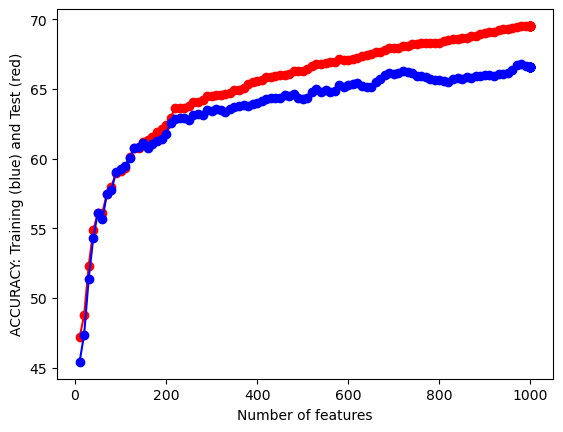

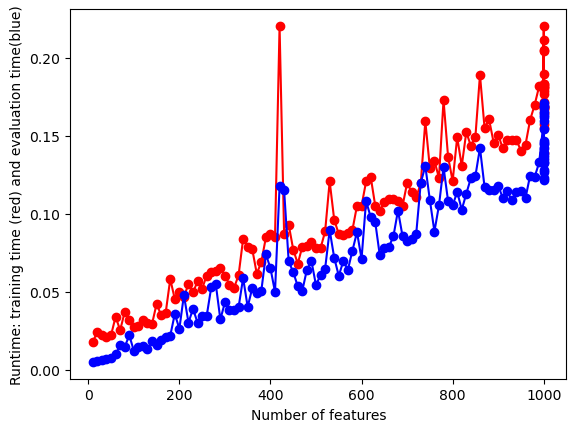

In [33]:
# Plotting

#PLOT-1
plt.plot(num_features,train_accuracies,'-or')
plt.plot(num_features,test_accuracies,'-ob')
plt.xlabel('Number of features')
plt.ylabel('ACCURACY: Training (blue) and Test (red)')
plt.show()

# Plot 2
plt.plot(num_features,train_time,'-or')
plt.plot(num_features,eval_time,'-ob')
plt.xlabel('Number of features')
plt.ylabel('Runtime: training time (red) and evaluation time(blue)')
plt.show()


We can see here that as our number of features begins to approach the maximum of 1000, both our test and training accuracies start to increase and then sort of level off. Our run time of the model does increase fairly substantially as we increase the number of features, but this run time is so small that it is negligible. I will be using all 1000 features of this data set. To reiterate, our original text data has close to 30,000 features, but the computing power neccessary to process all of these tweets is beyond the computing power at which is at my disposal. 1000 features is an optimal choice due to these constraints.

## Fitting a Final, "Optimal" NB Model
We will now use our subset of features to fit a final NB model. We will assess the model by looking at the metrics of accuracy, sensitivity (recall), precision, and F-1 score. A refresher on what these metrics are and their applications can be found [here](https://towardsdatascience.com/guide-to-confusion-matrices-classification-performance-metrics-a0ebfc08408e#:~:text=Confusion%20matrices%20can%20be%20used,%2C%20recall%2C%20and%20F1%20score.). As a reminder, a classification of 0 means "negative", 1 is "positive", and 2 is "neutral".


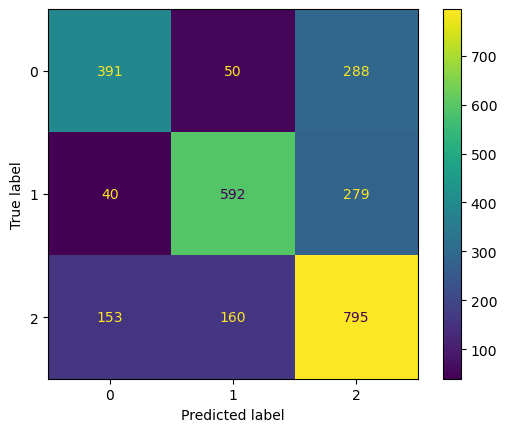

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
x_train=x[train_index]
y_train=y[train_index].flatten()

x_test=x[test_index]
y_test=y[test_index].flatten()

clf = MultinomialNB()
clf.fit(x_train,y_train)

yp_test = clf.predict(x_test)
cm = confusion_matrix(y_test, yp_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [39]:
Sensitivity = np.mean(np.diag(cm) / np.sum(cm, axis = 1))
Precision = np.mean(np.diag(cm) / np.sum(cm, axis = 0))
F1_score = 2 / ((1/Sensitivity) + (1/Precision))
print("Accuracy:", acc_test)
print("Precision:", Precision*100)
print("Sensitivity:",Sensitivity*100)
print("F1 Score:",F1_score*100)

Accuracy: 66.5938864628821
Precision: 68.69118070244866
Sensitivity: 65.54440091919668
F1 Score: 67.08090706180225


As we can see, our overall model accuracy is approximately 66% which is fairly strong. Our precision and sensitivity are also of similar strength, showing that our model's ability to correctly predict both positive and negative outputs for negative (0), positive (1), and neutral (2) tweets are pretty strong. The F1 score, which weights our precision and sensitity values, show us that our model overall is fairly strong in predicting all classes (with a score of 67%), as opposed to our Categorial Naive Bayes model for our record data in the other Naive Bayes tab.


# Testing our Classifier on HJKC Tweets
I will now show how this classifier could be used with tweets surrounding specific horses at HKJC. We will now use the data we collected through the Twitter API, tweets about the horse Golden Sixty, to show how this classifier would work in a real-life application.

Let's read in the data.

In [27]:
golden = pd.read_csv("../../../data/01-modified-data/goldensixty.csv")

Let's now make sure our data is properly formatted for the classifier.

In [26]:
import scipy.sparse
# Ensure X_new_vectorized has 1000 features, which is what our classifier was trained on
if golden.shape[1] < 1000:
    # Create a new feature matrix with 1000 features
    missing_features = 1000 - golden.shape[1]
    additional_features = scipy.sparse.csr_matrix((golden.shape[0], missing_features), dtype=int)
    golden = scipy.sparse.hstack([golden, additional_features])
new_predictions = clf.predict(golden)

Now I am going to create a table that shows the original tweets with their new text data classifications. As a reminder, a classification of 0 means "negative", 1 is "positive", and 2 is "neutral".

In [39]:
og_tweets = pd.read_csv('../../../data/01-modified-data/goldensixty_uncleaned.csv')
new_predictions = pd.DataFrame(new_predictions)
new_df = pd.concat([og_tweets, new_predictions], axis = 1)

new_df.head(10)

,0,0
0,rt hkjcracing the mile championship winner is ...,2.0
1,rt hongkongracing golden sixty sets out to mak...,2.0
2,rt hongkongracing golden sixty sets out to mak...,0.0
3,hes done his job hong kong superstar golden si...,0.0
4,tantriceden you can be my santa also you are t...,2.0
5,rt hkjcracing he has over hong kong wins and i...,2.0
6,rt hkjcracing great training performance by jo...,0.0
7,golden sixty httpst cokiufkxst,0.0
8,he has over hong kong wins and is golden sixty...,1.0
9,rt hongkongracing a fairytale finale for golde...,2.0


Theoretically, the tweets above should have been about 66% correctly assigned the correct sentiment.

## Conclusion
Overall, our model serves as a fantastic basis for classifying sentiment behind a tweet, especially if we are constrained on time for looking at tweets individually. Our model can serve as a strong basis for analyzing tweets pertaining to Hong Kong horse racing and public perception surrounding certain horses. Because horse racing odds in a parimutel betting market are directly reliant upon the betting public, having a model that is able to succesfully classify (most of the time) the sentiment behind any tweet concerning any race, course, or horse, we become even closer to identifying not only all factors relating to what drives the public to bet the way they do, but also quantifying the influence of the betting public. These findings will be reported in the final conclusive report generated from this project, likely alongside the generated model predicting sentiment behind actual HKJC-related tweets.